## O que vamos ver hoje:
Bloco 1
- Case e contexto de negócio
- Revisão Regressão logística (classificação vs regressão)
- Revisão Matriz de confusão
- Revisão Roc Curve, Precision e recall

Bloco 2
- Carregando e limpando o dataset
- Pre-processamento dos dados
- Implementação do modelo

## O que vamos ver hoje:
Bloco 3
- Class weight e hiperparâmetros
- Resampling
- Under e Over sampling
- Smote

Bloco 4
- Comparando os modelos
- Dúvidas

## Contexto de negócio
A empresa MyBank, visando expandir sua operação, deseja comprar uma carteira de clientes de um emissora de cartão de crédito com sede em Taiwan. Como parte do contrato a MyBank deseja revisar a política de crédito para pelo menos **50% dos possíveis futuros inadimplentes** (ajustar limite e taxa de juros). Além disso, para melhor precificar a compra ela **deseja saber a perda esperada dessa carteira no próximo mês**.

Você é um consultor de Data Science contratado pela MyBank para auxiliar a empresa durante essa aquisição.

## Contexto de negócio
**Objetivos**:
- Criar um modelo de probabilidade de inadimplência usando os dados históricos da operadora taiwanese
- Precificar a perda esperada da nova carteira de clientes

## Contexto análitico
* **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* **SEX**: Gender (1=male, 2=female)
* **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
* **AGE**: Age in years
* **PAY_0 - PAY_6**: Repayment status in September-April, 2005
    * -1=pay duly, 1=payment delay for one month
    *  2=payment delay for two months, … 
    *  8=payment delay for eight months, 9=payment delay for nine months and above
* **BILL_AMT1 - BILL_AMT6**: Amount of bill statement in September-April, 2005 (NT dollar)
* **PAY_AMT0 - PAY_AMT6**: Amount of previous payment in September-April, 2005 (NT dollar)                       
* **default.payment.next.month**: Default payment (1=yes, 0=no)


## Revisão Regressão logística

$
\begin{align}
\text{Odds}(\text{default}) = \frac{p}{1-p} \\
\end{align}
$

$
\begin{align}
\log(\text{Odds}) = \beta_0 + \beta_1*\text{hours} \\
\end{align}
$


$
\begin{align}
p=\frac{1}{1+e^{-(\beta_0 + \beta_1*\text{hours})}}
\end{align}
$

![](imgs/logistic_curve.jpeg)

Recap classificação, Recap regressão

## Em resumo (Regressão logística)

![](imgs/logit_diagram_v1.png)

## Interpretando os coeficientes da regressão logística

In [1]:
import pandas as pd
import numpy as np

In [2]:
import statsmodels.api as sm

df_logit = pd.read_csv('data/UCI_Credit_Card.csv')
df_logit['EDUCATION'] = df_logit.EDUCATION.map({1:1, 2:2, 3:3, 4:0, 5:np.nan, 6:np.nan})
df_logit['intercept'] = 1
df_logit.dropna(subset=['EDUCATION'], inplace=True)

# log(odds) ~ b0 + b1*education
logit_res = sm.Logit(df_logit['default.payment.next.month'], df_logit[['intercept','EDUCATION']]).fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.528880
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default.payment.next.month   No. Observations:                29655
Model:                                  Logit   Df Residuals:                    29653
Method:                                   MLE   Df Model:                            1
Date:                        Mon, 08 Feb 2021   Pseudo R-squ.:                0.003147
Time:                                18:37:33   Log-Likelihood:                -15684.
converged:                               True   LL-Null:                       -15733.
Covariance Type:                    nonrobust   LLR p-value:                 2.480e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.6066      0.039    -41.144      0.000      -1.683      -1.530
EDUCATION      0.1958      0.020      9.957      0.000       0.157       0.234
==============================================================================
"""

## Revisão Matriz de confusão
![](imgs/confusion.jpg)

## Revisão Precision, Recall e F1
* **Acurácia**: O quanto o modelo consegue acertar
* **recall (sensitivity)**: Do universo dos positivos, quantos o modelo consegue recuperar
* **precision**: Quando o modelo falou que era positivo, quantos eram de fato
* **F1-measure**: média harmônica entre o precision e o recall

## Revisão ROC AUC e PR AUC
![](imgs/pr_roc_curves.png)

## Importando as bibliotecas

In [3]:
%matplotlib notebook
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

In [4]:
# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Pre-processing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import  precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [5]:
%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Carregando o dataset

In [6]:
df = pd.read_csv('data/UCI_Credit_Card.csv')
df.drop('ID', axis=1, inplace=True)
df = df.rename(columns={'default.payment.next.month': 'default', 'PAY_0': 'PAY_1'})
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Verificando o tipo das variáveis

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

## Distribuição da variável de interesse

In [8]:
df_unbalanced = df.drop(df[df.default == 1].sample(frac=.7).index)
print('Original')
print(df.default.value_counts())
print('More unbalanced')
print(df_unbalanced.default.value_counts())

Original
0    23364
1     6636
Name: default, dtype: int64
More unbalanced
0    23364
1     1991
Name: default, dtype: int64


In [9]:
positive_proportion = df_unbalanced.default.value_counts()[1]/(len(df_unbalanced))
print('Proporção de inadimplentes:', round(positive_proportion,2)*100, '%')

Proporção de inadimplentes: 8.0 %


## Organizando as features

In [10]:
target = 'default'

cat_features = [
    'SEX',
    'EDUCATION',
    'MARRIAGE'
]

num_features = [
    'LIMIT_BAL','AGE',
    'PAY_1','PAY_2','PAY_3',
    'PAY_4','PAY_5','PAY_6',
    'BILL_AMT1','BILL_AMT2','BILL_AMT3',
    'BILL_AMT4','BILL_AMT5','BILL_AMT6',
    'PAY_AMT1','PAY_AMT2','PAY_AMT3',
    'PAY_AMT4','PAY_AMT5','PAY_AMT6'
]

## Pre-processamento


In [11]:
df_proc = pd.get_dummies(df_unbalanced, columns=cat_features, drop_first=True)
df_proc.drop(num_features, axis=1).head()

,default,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
1,1,1,0,1,0,0,0,0,0,1,0
2,0,1,0,1,0,0,0,0,0,1,0
3,0,1,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,0,0
5,0,0,1,0,0,0,0,0,0,1,0


* **SEX**: Gender (0=NA, 1=male, 2=female)
* **EDUCATION**: (0=NA, 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* **MARRIAGE**: Marital status (0=NA, 1=married, 2=single, 3=others)

In [12]:
# Dever de casa testar sem StandardScaler
scaler = StandardScaler()
df_proc[num_features] = scaler.fit_transform(df_proc[num_features])
df_proc[num_features].head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
1,-0.415232,-1.033370,-0.838876,2.044251,0.239311,0.287842,0.333345,2.234052,-0.666852,-0.673185,-0.643444,-0.625007,-0.610157,-0.600800,-0.347165,-0.219560,-0.246093,-0.253620,-0.324706,-0.192446
2,-0.644151,-0.155883,0.141340,0.221652,0.239311,0.287842,0.333345,0.344520,-0.306138,-0.500150,-0.486883,-0.453092,-0.420619,-0.393976,-0.260428,-0.199209,-0.246093,-0.253620,-0.260789,-0.030851
3,-0.949376,0.173174,0.141340,0.221652,0.239311,0.287842,0.333345,0.344520,-0.065033,-0.019024,0.027434,-0.235722,-0.189554,-0.158370,-0.232887,-0.178084,-0.235313,-0.247502,-0.256378,-0.246311
4,-0.949376,2.366891,-0.838876,0.221652,-0.667944,0.287842,0.333345,0.344520,-0.586239,-0.617696,-0.166248,-0.350353,-0.351387,-0.333686,-0.232887,1.232774,0.239007,0.235821,-0.280667,-0.263602
5,-0.949376,0.173174,0.141340,0.221652,0.239311,0.287842,0.333345,0.344520,0.171441,0.105259,0.147147,-0.374386,-0.343586,-0.318656,-0.204318,-0.186387,-0.264581,-0.253620,-0.260789,-0.257084


## Splitando os dados

In [13]:
# Features
X = df_proc.drop('default', axis=1)
# Target variable
y = df_proc.default
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

## Hiperparâmetros

![](imgs/model_diagram.png)

In [14]:
model_example =  LogisticRegression(class_weight={0:1,1:10}, max_iter=2000)

## Random forest

![](imgs/random-forest-algorithm2.png)

Link sobre random forest stat quest: https://www.youtube.com/watch?v=J4Wdy0Wc_xQ

## Comparando o Random Forest com diferentes class_weights

In [15]:
def check_mutiple_class_weights():
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')

    for w,k in zip([1,2,5,10],'bgrcmykw'):
        #lr_model = LogisticRegression(class_weight={0:1,1:w}, max_iter=2000)
        lr_model = RandomForestClassifier(class_weight={0:1,1:w})
        lr_model.fit(X_train,y_train)
        pred_prob = lr_model.predict_proba(X_test)[:,1]

        p,r,_ = precision_recall_curve(y_test,pred_prob)
        tpr,fpr,_ = roc_curve(y_test,pred_prob)

        ax1.plot(r,p,c=k,label=w)
        ax2.plot(tpr,fpr,c=k,label=w)
    ax1.legend(loc='lower right')    
    ax2.legend(loc='lower right')

    plt.show()

## Comparando Logit com diferentes class_weight

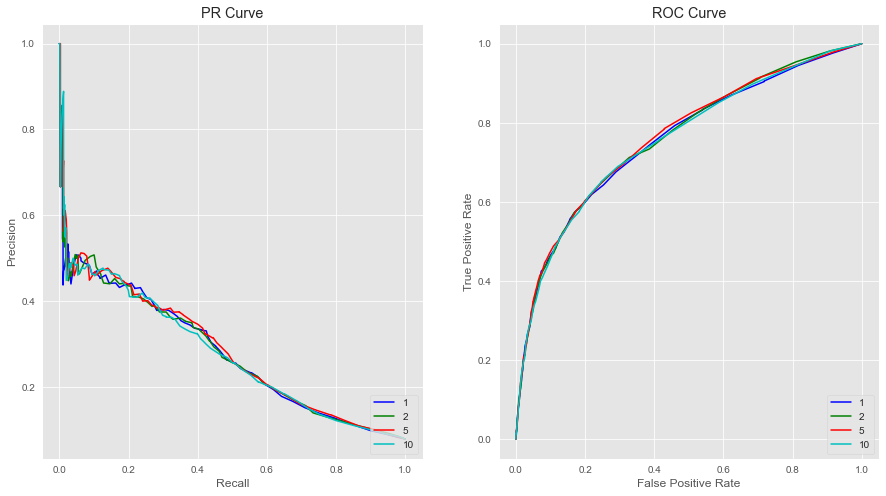

In [17]:
check_mutiple_class_weights()

## Estratégias de balanceamento

![](imgs/balancing.png)

## Criando datasets de treino balanceados

In [18]:
from collections import Counter 

randUnderSampler = RandomUnderSampler(random_state=42)
X_rus, y_rus = randUnderSampler.fit_resample(X_train, y_train)

randOverSampler = RandomOverSampler(random_state=42)
X_ros, y_ros = randOverSampler.fit_resample(X_train, y_train)

print('Original dataset: ', Counter(y_train))
print('Undersampled dataset: ', Counter(y_rus))
print('Overampled dataset: ', Counter(y_ros))

Original dataset:  Counter({0: 15653, 1: 1334})
Undersampled dataset:  Counter({0: 1334, 1: 1334})
Overampled dataset:  Counter({0: 15653, 1: 15653})


## Criando modelos com diferentes técnicas

In [19]:
# Fit a model without balacing technics
# model_baseline = LogisticRegression(max_iter=2000, random_state=42)
model_baseline = RandomForestClassifier()
model_baseline.fit(X_train, y_train)

# Fit a model with class weight
# model_weighted = LogisticRegression(max_iter=2000, random_state=42, class_weight={0:1,1:2})
model_weighted = RandomForestClassifier(class_weight={0:1,1:2})
model_weighted.fit(X_train, y_train)

# Fit model without random under sampling
# model_rus = LogisticRegression(max_iter=2000, random_state=42)
model_rus = RandomForestClassifier(class_weight={0:1,1:2})
model_rus.fit(X_rus, y_rus)

# Fit model without random over sampling
# model_ros = LogisticRegression(max_iter=2000, random_state=42)
model_ros = RandomForestClassifier(class_weight={0:1,1:2})
model_ros.fit(X_ros, y_ros)

RandomForestClassifier(class_weight={0: 1, 1: 2})

# Comparando a matriz de confusão (Random Undersampling)

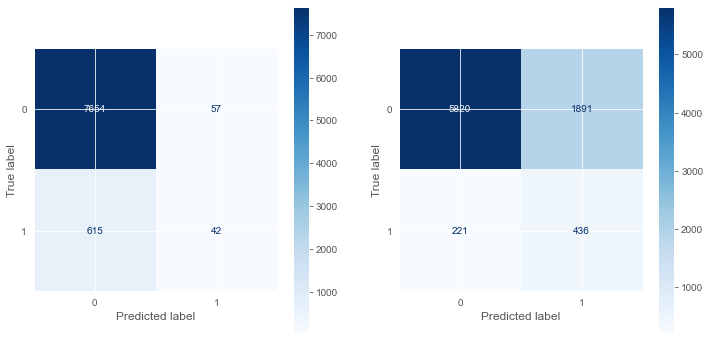

In [20]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plot_confusion_matrix(model_baseline, X_test, y_test, cmap='Blues', ax=ax1)
plot_confusion_matrix(model_rus, X_test, y_test, cmap='Blues', ax=ax2)
plt.show()

# Comparando a matriz de confusão (Random Oversampling)

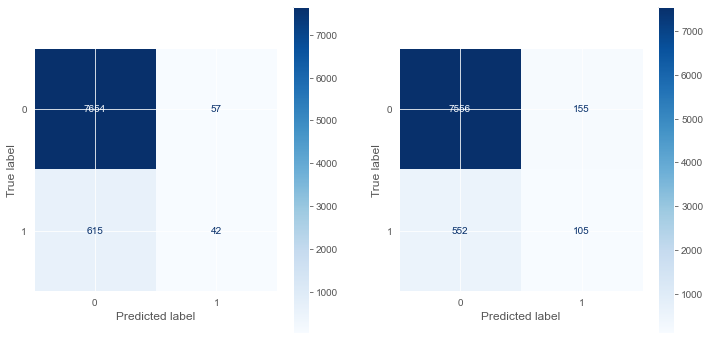

In [21]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plot_confusion_matrix(model_baseline, X_test, y_test, cmap='Blues', ax=ax1)
plot_confusion_matrix(model_ros, X_test, y_test, cmap='Blues', ax=ax2)
plt.show()

## SMOTE
Synthetic Minority OverSampling Technique

![](imgs/smote2.png)

## K-NN
![](imgs/knn.png)

## Criando um modelo usando SMOTE

## SMOTE
* SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de oversampling
* Ela funciona criando sinteticamente novos exemplos da classe minoritária, baseando-se nos exemplos existentes da classe.
* Isso é feito escolhendo aleatoriamente um exemplo da classe minoritária e encontrando o seu k-vizinho mais próximo.
* Então, um novo exemplo é criado adicionando uma pequena quantidade de variação entre o exemplo escolhido e seu vizinho mais próximo.
* Isso ajuda a aumentar a representatividade da classe minoritária no conjunto de dados.

In [22]:
## SMOTE

Smote Oversampled dataset:  Counter({0: 15653, 1: 3130})


RandomForestClassifier()

# Comparando a matriz de confusão (SMOTE)

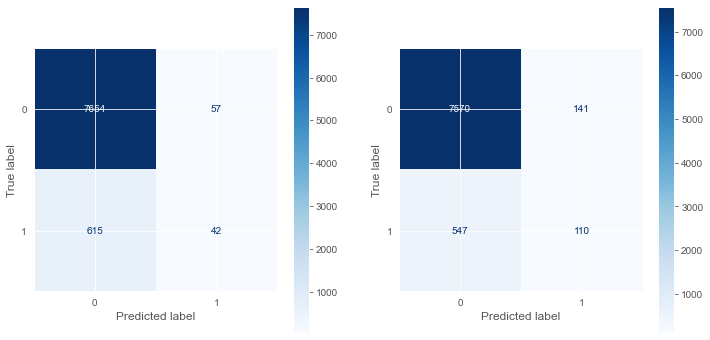

In [23]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plot_confusion_matrix(model_baseline, X_test, y_test, cmap='Blues', ax=ax1)
plot_confusion_matrix(model_smote, X_test, y_test, cmap='Blues', ax=ax2)
plt.show()

In [24]:
# SKIPE FROM SLIDE
def compare_models():
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')

    models = [model_baseline, model_weighted, model_rus, model_ros, model_smote]
    names =  ['baseline', 'weighted', 'rus', 'ros', 'smote']
    avg_p = []
    roc_auc = []
    for model,name, k in zip(models, names, 'bgrcmykw'):
        pred_prob = model.predict_proba(X_test)[:,1]
        p,r,_ = precision_recall_curve(y_test,pred_prob)

        roc_auc.append(round(roc_auc_score(y_test, pred_prob), 3))
        avg_p.append(round(average_precision_score(y_test, pred_prob), 3))

        tpr,fpr,_ = roc_curve(y_test,pred_prob)
        ax1.plot(r,p,c=k,label=name, alpha=0.8,  linewidth=0.7)
        ax2.plot(tpr,fpr,c=k,label=name, alpha=0.8,  linewidth=0.7)

    ax1.legend(loc='lower right')    
    ax2.legend(loc='lower right')
    
    plt.show()
    return  pd.DataFrame({'models' : names, 'avg. precision': avg_p, 'roc auc': roc_auc})

## Comparando os diferentes classificadores

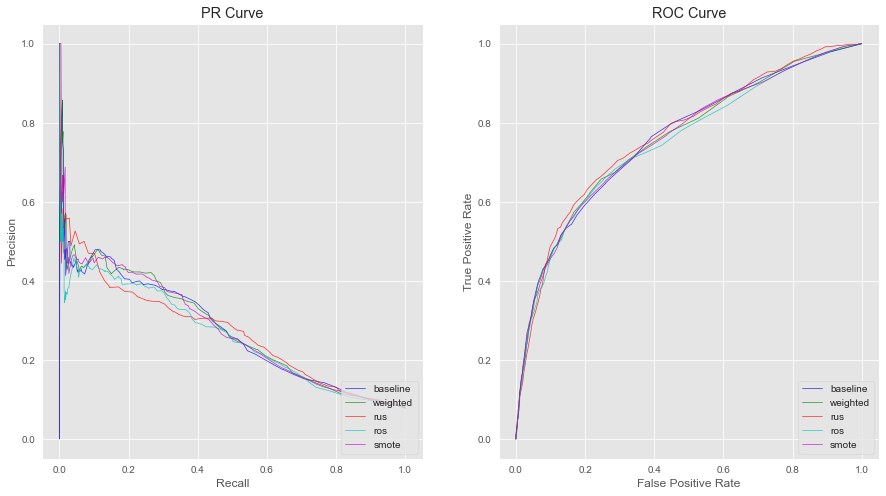

In [25]:
compare_df = compare_models()

## Comparando os diferentes classificadores

In [26]:
compare_df

,models,avg. precision,roc auc
0,baseline,0.270,0.760
1,weighted,0.273,0.758
2,rus,0.266,0.767
3,ros,0.256,0.750
4,smote,0.272,0.757


## Computando as probabilidades

In [27]:
# Get predicted probabilities
y_pred_probs = model_smote.predict_proba(X_test)
print('Positive class probs: ', y_pred_probs[:,1])
print('Negative class probs: ', y_pred_probs[:,0])

# Get predicted class, treshold 0.4
y_pred = (y_pred_probs[:,1] >= 0.4).astype(int)
print('class predictions (threshold 0.4): ', y_pred)

Positive class probs:  [0.12 0.39 0.07 ... 0.02 0.06 0.13]
Negative class probs:  [0.88 0.61 0.93 ... 0.98 0.94 0.87]
class predictions (threshold 0.4):  [0 0 0 ... 0 0 0]


In [ ]:
# Testar diferentes tresholds Matriz de confusão

## Métricas de avaliação do modelo

In [28]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-Score:', f1_score(y_test, y_pred))

Accuracy: 0.9079827915869981
Precision: 0.38585858585858585
Recall: 0.2907153729071537
F1-Score: 0.3315972222222222


## ROC Curve

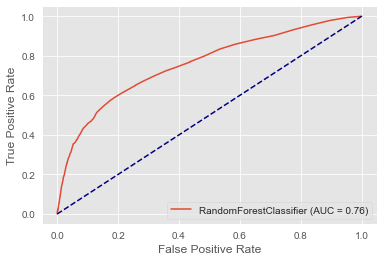

In [29]:
plot_roc_curve(model_smote, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()  

*Questionamento*: qual é o baseline ?

Vamos calcular na mão a TPR e o FPR para o baseline (chutar tudo positivo, chutart tudo zero).

## Precision Recall Curve (datasets desbalanceados)

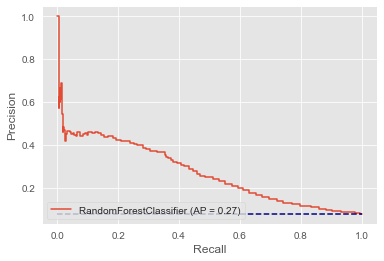

In [30]:
disp = plot_precision_recall_curve(model_smote, X_test, y_test)
plt.plot([0,1], [positive_proportion, positive_proportion], color='navy', linestyle='--')
plt.show()

## Fim
dever de casa, testar as diferentes técnicas com a regressão logistica

Materias de Apoio


notas

* If X never equals 0, then the intercept has no intrinsic meaning. In scientific research, the purpose of a regression model is to understand the relationship between predictors and the response.  If so, and if X never = 0, there is no interest in the intercept. It doesn’t tell you anything about the relationship between X and Y.